#**Customer Segmentation**
Kelompok 12
1.   **Kevin Wijaya / C14210124**
2.   **Nicholas Lawrentius Setyadharma / C14210121**
3.   **Gwanardi Halim / C14210068**






link dataset: https://www.kaggle.com/code/fabiendaniel/customer-segmentation

### Attribute Information:
- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction.** If this code starts with the letter 'c', it indicates a cancellation.**  
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
- Description: Product (item) name. Nominal.  
- Quantity: The quantities of each product (item) per transaction. Numeric.  
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.  
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
- Country: Country name. Nominal, the name of the country where each customer resides.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import math
%matplotlib notebook
%matplotlib inline

In [ ]:
# baca filenya
df = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# format ulang invoicedate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Data Preprocessing

In [ ]:
# cek data duplicate
df.duplicated().sum()

5268

In [ ]:
# drop data duplicate
df.drop_duplicates(inplace=True)

In [ ]:
# hilangkan baris yg ada kosong
df.dropna(inplace=True)

In [ ]:
df = df[df['Quantity'] > 0]

In [ ]:
# convert jadi string
df['CustomerID'] = df['CustomerID'].astype(str)

In [ ]:
df.shape

(392732, 8)

In [ ]:
# EDA
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  object        
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB
None


In [ ]:
# EDA
print(df.describe())

            Quantity      UnitPrice
count  392732.000000  392732.000000
mean       13.153718       3.125596
std       181.588420      22.240725
min         1.000000       0.000000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000


In [ ]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('jumlah negara di mana ada order: {}'.format(len(countries)))

jumlah negara di mana ada order: 37


In [ ]:
# hitung jumlah produk, transaksi, dan customers
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3665,18536,4339


In [ ]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
jumlah_product_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
jumlah_product_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12347.0,537626,31
2,12347.0,542237,29
3,12347.0,549222,24
4,12347.0,556201,18
5,12347.0,562032,22
6,12347.0,573511,47
7,12347.0,581180,11
8,12348.0,539318,17
9,12348.0,541998,6


# RFM

In [ ]:
# RFM
# frequency seberapa sering belanja
frequency = df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'Count']
print(frequency)

     CustomerID  Count
0       12346.0      1
1       12347.0    182
2       12348.0     31
3       12349.0     73
4       12350.0     17
...         ...    ...
4334    18280.0     10
4335    18281.0      7
4336    18282.0     12
4337    18283.0    721
4338    18287.0     70

[4339 rows x 2 columns]


In [ ]:
# recency seberapa sering datang untuk belanja (brp hari sejak terakhir belanja)
max_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency.columns = ['CustomerID', 'Latest Date']
recency['Recency'] = (max_date - recency['Latest Date']).dt.days
recency = recency[['CustomerID', 'Recency']]
print(recency)

     CustomerID  Recency
0       12346.0      326
1       12347.0        2
2       12348.0       75
3       12349.0       19
4       12350.0      310
...         ...      ...
4334    18280.0      278
4335    18281.0      181
4336    18282.0        8
4337    18283.0        4
4338    18287.0       43

[4339 rows x 2 columns]


In [ ]:
# customer spend
df['Spending'] = df['Quantity'] * df['UnitPrice']
monetary = df.groupby('CustomerID')['Spending'].sum()
monetary = monetary.reset_index()
print(monetary)

     CustomerID  Spending
0       12346.0  77183.60
1       12347.0   4310.00
2       12348.0   1797.24
3       12349.0   1757.55
4       12350.0    334.40
...         ...       ...
4334    18280.0    180.60
4335    18281.0     80.82
4336    18282.0    178.05
4337    18283.0   2045.53
4338    18287.0   1837.28

[4339 rows x 2 columns]


In [ ]:
rfm_df = pd.merge(recency, frequency, on='CustomerID', how='inner')
rfm_df = pd.merge(rfm_df, monetary, on='CustomerID', how='inner')
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(rfm_df)

     CustomerID  Recency  Frequency  Monetary
0       12346.0      326          1  77183.60
1       12347.0        2        182   4310.00
2       12348.0       75         31   1797.24
3       12349.0       19         73   1757.55
4       12350.0      310         17    334.40
...         ...      ...        ...       ...
4334    18280.0      278         10    180.60
4335    18281.0      181          7     80.82
4336    18282.0        8         12    178.05
4337    18283.0        4        721   2045.53
4338    18287.0       43         70   1837.28

[4339 rows x 4 columns]


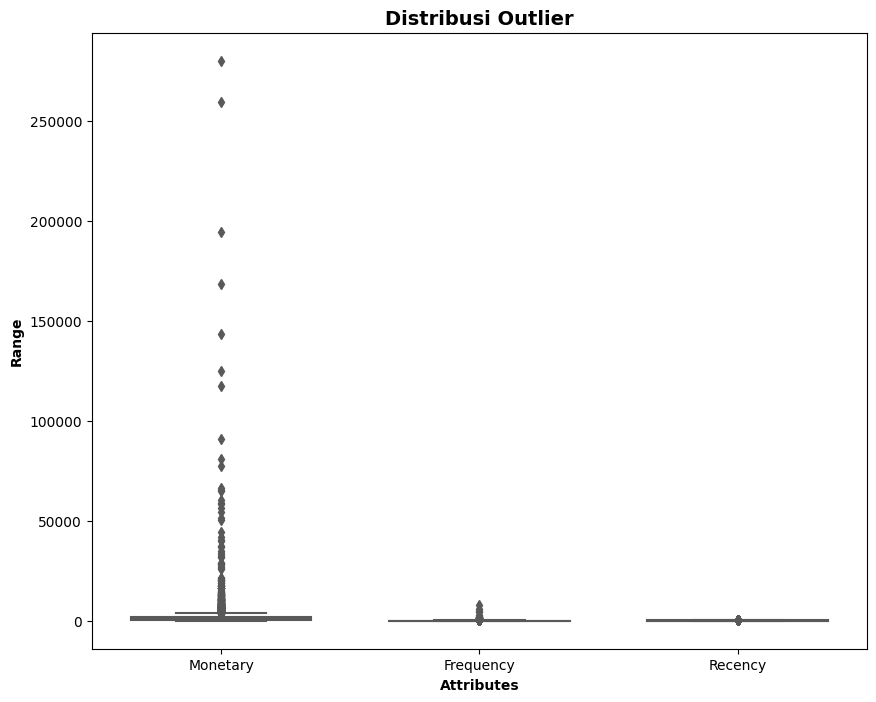

In [ ]:
attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm_df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Distribusi Outlier", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')
plt.show()

In [ ]:
# remove outlier
Q1 = rfm_df.Monetary.quantile(0.05)
Q3 = rfm_df.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.Monetary >= Q1 - 1.5*IQR) & (rfm_df.Monetary <= Q3 + 1.5*IQR)]

In [ ]:
Q1 = rfm_df.Recency.quantile(0.05)
Q3 = rfm_df.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.Recency >= Q1 - 1.5*IQR) & (rfm_df.Recency <= Q3 + 1.5*IQR)]

In [ ]:
Q1 = rfm_df.Frequency.quantile(0.05)
Q3 = rfm_df.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_df = rfm_df[(rfm_df.Frequency >= Q1 - 1.5*IQR) & (rfm_df.Frequency <= Q3 + 1.5*IQR)]

In [ ]:
rfm_df_id = rfm_df[['CustomerID']]

In [ ]:
rfm_df = rfm_df[['Monetary', 'Frequency', 'Recency']]
print(rfm_df)

      Monetary  Frequency  Recency
1      4310.00        182        2
2      1797.24         31       75
3      1757.55         73       19
4       334.40         17      310
5      2506.04         85       36
...        ...        ...      ...
4334    180.60         10      278
4335     80.82          7      181
4336    178.05         12        8
4337   2045.53        721        4
4338   1837.28         70       43

[4258 rows x 3 columns]


In [ ]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
print(quantiles)

{'Monetary': {0.25: 302.61, 0.5: 652.77, 0.75: 1566.7925}, 'Frequency': {0.25: 17.0, 0.5: 39.0, 0.75: 95.0}, 'Recency': {0.25: 19.0, 0.5: 52.0, 0.75: 145.0}}


In [ ]:
def RScoring(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4


def FnMScoring(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [ ]:
rfm_df['R'] = rfm_df['Recency'].apply(RScoring, args=('Recency',quantiles,))
rfm_df['F'] = rfm_df['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
rfm_df['M'] = rfm_df['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
print(rfm_df.head())

   Monetary  Frequency  Recency  R  F  M
1   4310.00        182        2  1  1  1
2   1797.24         31       75  3  3  1
3   1757.55         73       19  1  2  1
4    334.40         17      310  4  4  3
5   2506.04         85       36  2  2  1


In [ ]:
rfm_df['RFMGroup'] = rfm_df.R.map(str) + rfm_df.F.map(str) + rfm_df.M.map(str)
rfm_df['RFMScore'] = rfm_df[['R', 'F', 'M']].sum(axis = 1)
print(rfm_df.head())

   Monetary  Frequency  Recency  R  F  M RFMGroup  RFMScore
1   4310.00        182        2  1  1  1      111         3
2   1797.24         31       75  3  3  1      331         7
3   1757.55         73       19  1  2  1      121         4
4    334.40         17      310  4  4  3      443        11
5   2506.04         85       36  2  2  1      221         5


In [ ]:
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num

In [ ]:
rfm_df['Recency'] = [handle_neg_n_zero(x) for x in rfm_df.Recency]
rfm_df['Monetary'] = [handle_neg_n_zero(x) for x in rfm_df.Monetary]

<ipython-input-266-c59e0c38b875>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Recency', ylabel='Density'>

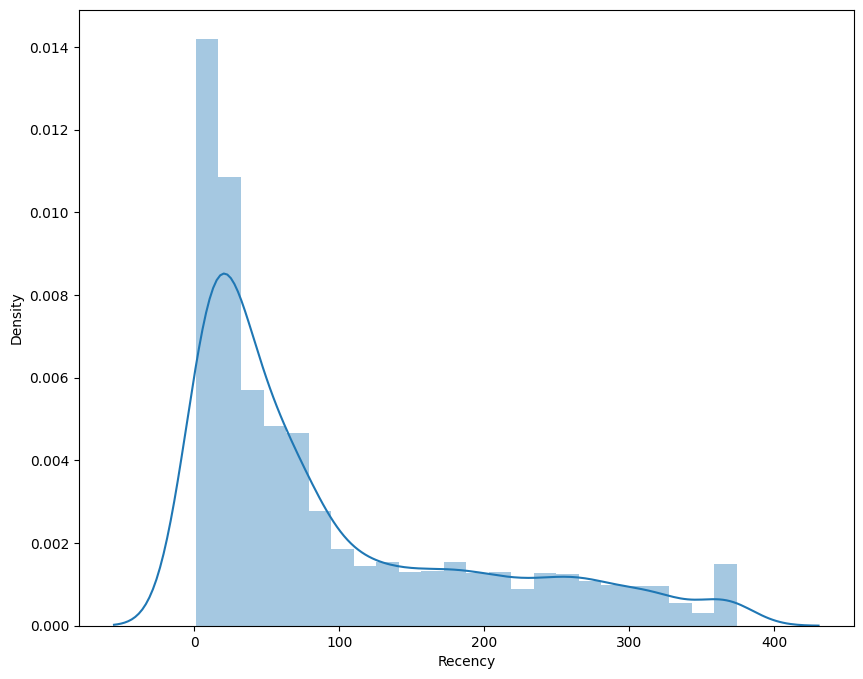

In [ ]:
# plot distribusi recency
sns.distplot(rfm_df['Recency'])

<ipython-input-267-0de240a45a8b>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Frequency', ylabel='Density'>

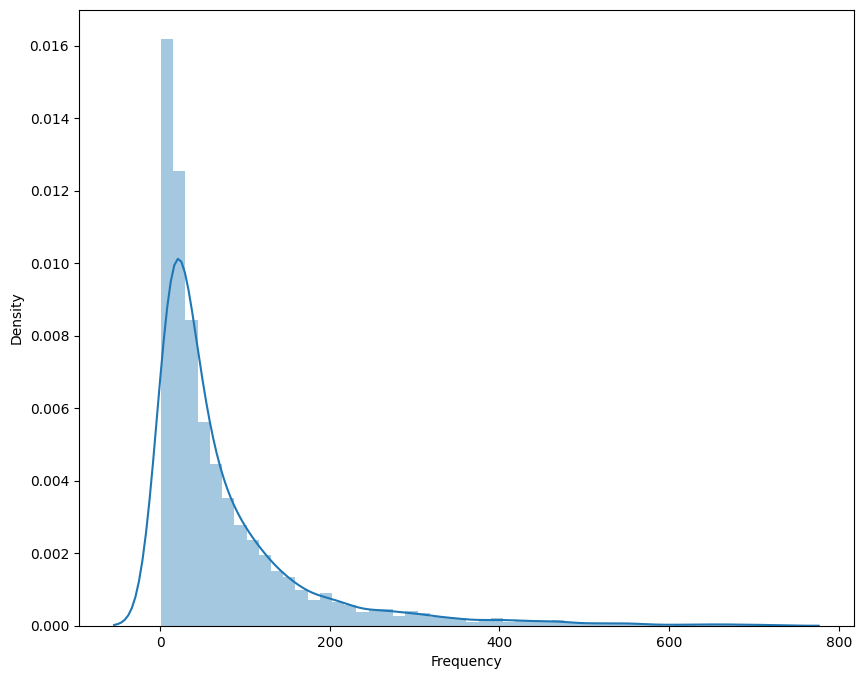

In [ ]:
# plot distribusi frequency
sns.distplot(rfm_df['Frequency'])

<ipython-input-268-75fef064f77e>:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: xlabel='Monetary', ylabel='Density'>

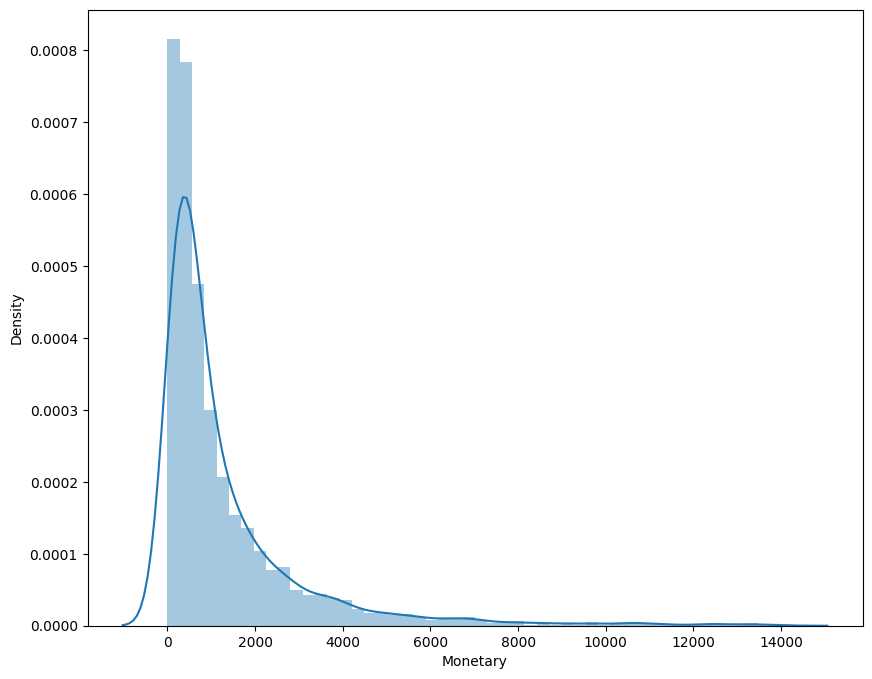

In [ ]:
# plot distribusi monetary
sns.distplot(rfm_df['Monetary'])

In [ ]:
rfm_df['Recency_log'] = rfm_df['Recency'].apply(math.log)
rfm_df['Frequency_log'] = rfm_df['Frequency'].apply(math.log)
rfm_df['Monetary_log'] = rfm_df['Monetary'].apply(math.log)

print(rfm_df)

      Monetary  Frequency  Recency  R  F  M RFMGroup  RFMScore  Recency_log  \
1      4310.00        182        2  1  1  1      111         3     0.693147   
2      1797.24         31       75  3  3  1      331         7     4.317488   
3      1757.55         73       19  1  2  1      121         4     2.944439   
4       334.40         17      310  4  4  3      443        11     5.736572   
5      2506.04         85       36  2  2  1      221         5     3.583519   
...        ...        ...      ... .. .. ..      ...       ...          ...   
4334    180.60         10      278  4  4  4      444        12     5.627621   
4335     80.82          7      181  4  4  4      444        12     5.198497   
4336    178.05         12        8  1  4  4      144         9     2.079442   
4337   2045.53        721        4  1  1  1      111         3     1.386294   
4338   1837.28         70       43  2  2  1      221         5     3.761200   

      Frequency_log  Monetary_log  
1          5.20

In [ ]:
rfm_log = rfm_df[['Monetary_log', 'Frequency_log', 'Recency_log']]
rfm_log

,Monetary_log,Frequency_log,Recency_log
1,8.368693,5.204007,0.693147
2,7.494007,3.433987,4.317488
3,7.471676,4.290459,2.944439
4,5.812338,2.833213,5.736572
5,7.826459,4.442651,3.583519
...,...,...,...
4334,5.196285,2.302585,5.627621
4335,4.392224,1.945910,5.198497
4336,5.182064,2.484907,2.079442
4337,7.623412,6.580639,1.386294


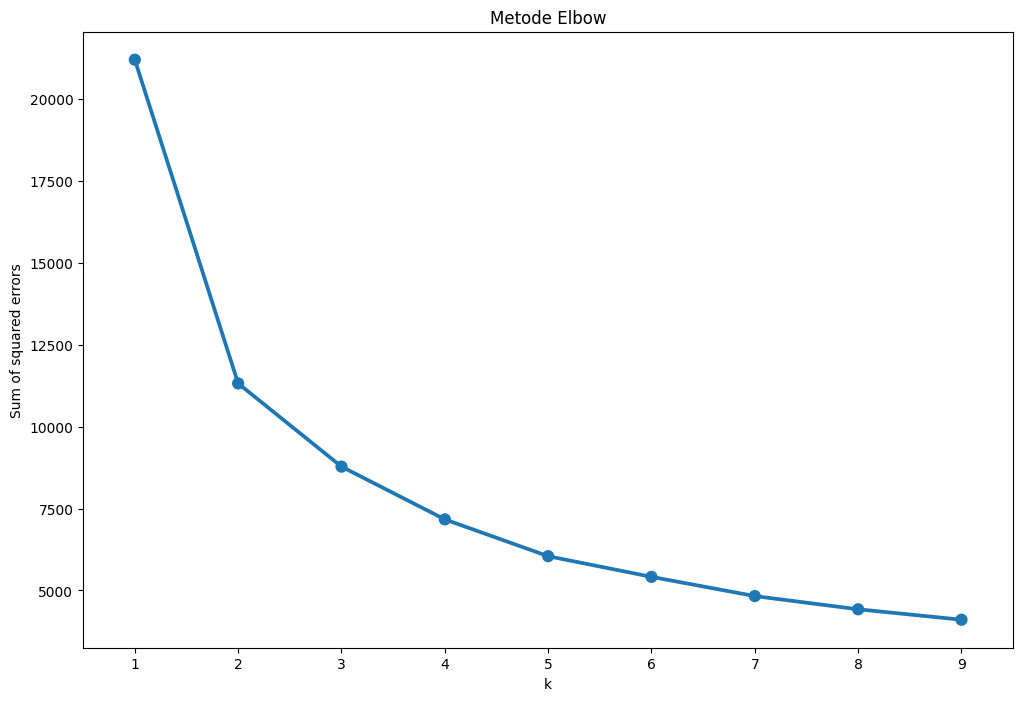

In [ ]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=1)

    kmeans.fit(rfm_log)

    sse[k] = kmeans.inertia_

# Plot elbow curvenya
plt.figure(figsize=(12,8))
plt.title('Metode Elbow')
plt.xlabel('k');
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
# pilih k = 4
kmeans_log = KMeans(n_clusters=4, n_init=10, max_iter=50)
kmeans_log.fit(rfm_log)
rfm_log.loc[:,'CustomerID'] = rfm_df_id['CustomerID']
rfm_log['cluster'] = kmeans_log.labels_
print(rfm_log)

      Monetary_log  Frequency_log  Recency_log CustomerID  cluster
1         8.368693       5.204007     0.693147    12347.0        3
2         7.494007       3.433987     4.317488    12348.0        2
3         7.471676       4.290459     2.944439    12349.0        3
4         5.812338       2.833213     5.736572    12350.0        1
5         7.826459       4.442651     3.583519    12352.0        2
...            ...            ...          ...        ...      ...
4334      5.196285       2.302585     5.627621    18280.0        1
4335      4.392224       1.945910     5.198497    18281.0        1
4336      5.182064       2.484907     2.079442    18282.0        0
4337      7.623412       6.580639     1.386294    18283.0        3
4338      7.516041       4.248495     3.761200    18287.0        2

[4258 rows x 5 columns]


<ipython-input-219-36ddfd098bee>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-219-36ddfd098bee>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'Plotting RFM'}, xlabel='Attribute', ylabel='Value'>

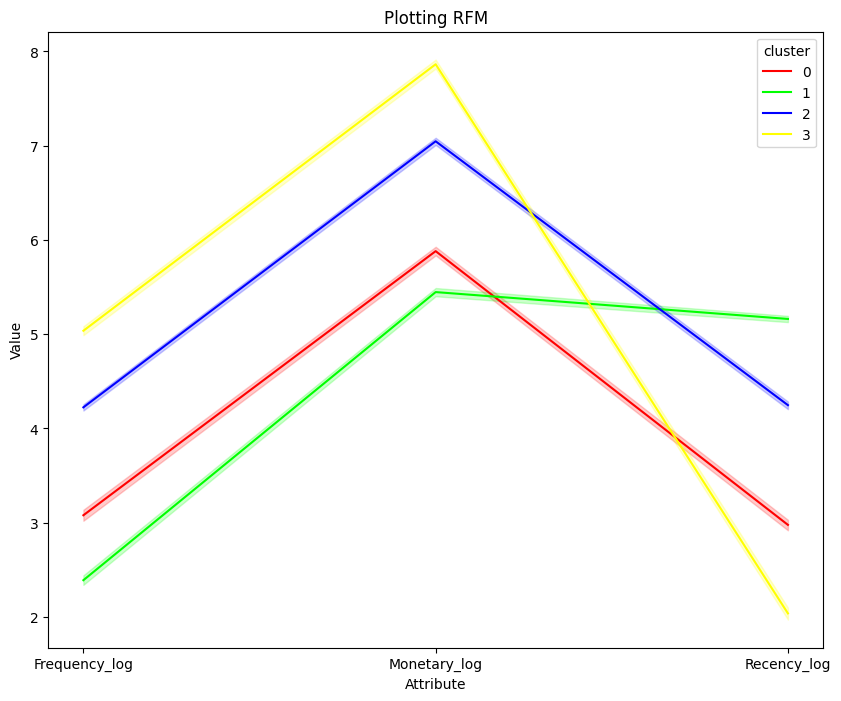

In [ ]:
data_melt = pd.melt(rfm_log.reset_index(),
                    id_vars=['CustomerID', 'cluster'],
                    value_vars=['Frequency_log', 'Monetary_log','Recency_log'],
                    var_name='Attribute',
                    value_name='Value')

custom_palette = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00"]
plt.title('Plotting RFM')
sns.lineplot(x="Attribute", y="Value", hue='cluster', data=data_melt, palette=custom_palette)

1. Cluster 3: customer yang ideal, yang sering belanja dan spend nya paling banyak. (frequency dan monetary tinggi, recency rendah)
2. Cluster 1: customer yang datang hanya sesekali saja karena frequency nya rendah dan recencynya tinggi, dan jumlah spendingnya kecil.
3. Cluster 0: frequency, monetary, dan recencynya biasa saja. Jadi ini tergolong customer yang cukup sering datang dan spent lumayan.
4. Cluster 2: ini customer yang frequency datangnya lumayan akan tetapi recencynya juga tinggi. Mirip seperti Cluster 2.

# RFM 3D Plotting

In [ ]:
print(rfm_df)

      Monetary  Frequency  Recency  R  F  M RFMGroup  RFMScore  Recency_log  \
1      4310.00        182        2  1  1  1      111         3     0.693147   
2      1797.24         31       75  3  3  1      331         7     4.317488   
3      1757.55         73       19  1  2  1      121         4     2.944439   
4       334.40         17      310  4  4  3      443        11     5.736572   
5      2506.04         85       36  2  2  1      221         5     3.583519   
...        ...        ...      ... .. .. ..      ...       ...          ...   
4334    180.60         10      278  4  4  4      444        12     5.627621   
4335     80.82          7      181  4  4  4      444        12     5.198497   
4336    178.05         12        8  1  4  4      144         9     2.079442   
4337   2045.53        721        4  1  1  1      111         3     1.386294   
4338   1837.28         70       43  2  2  1      221         5     3.761200   

      Frequency_log  Monetary_log  cluster fm  clus

In [ ]:
scaler = StandardScaler()
rfm_normalized = rfm_df[['Monetary', 'Frequency', 'Recency']]
print(rfm_normalized)
rfm_normalized = scaler.fit_transform(rfm_normalized)
rfm_normalized = pd.DataFrame(rfm_normalized)
print(rfm_normalized)
rfm_normalized.columns = ['Monetary', 'Frequency', 'Recency']

      Monetary  Frequency  Recency
1      4310.00        182        2
2      1797.24         31       75
3      1757.55         73       19
4       334.40         17      310
5      2506.04         85       36
...        ...        ...      ...
4334    180.60         10      278
4335     80.82          7      181
4336    178.05         12        8
4337   2045.53        721        4
4338   1837.28         70       43

[4258 rows x 3 columns]
             0         1         2
0     1.660541  1.082775 -0.917707
1     0.267485 -0.456323 -0.189082
2     0.245481 -0.028230 -0.748027
3    -0.543503 -0.599021  2.156491
4     0.660439  0.094083 -0.578347
...        ...       ...       ...
4253 -0.628769 -0.670370  1.837094
4254 -0.684086 -0.700948  0.868921
4255 -0.630182 -0.649985 -0.857820
4256  0.405135  6.576643 -0.897744
4257  0.289683 -0.058808 -0.508479

[4258 rows x 3 columns]


In [ ]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_normalized)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(max_iter=50, n_clusters=4)

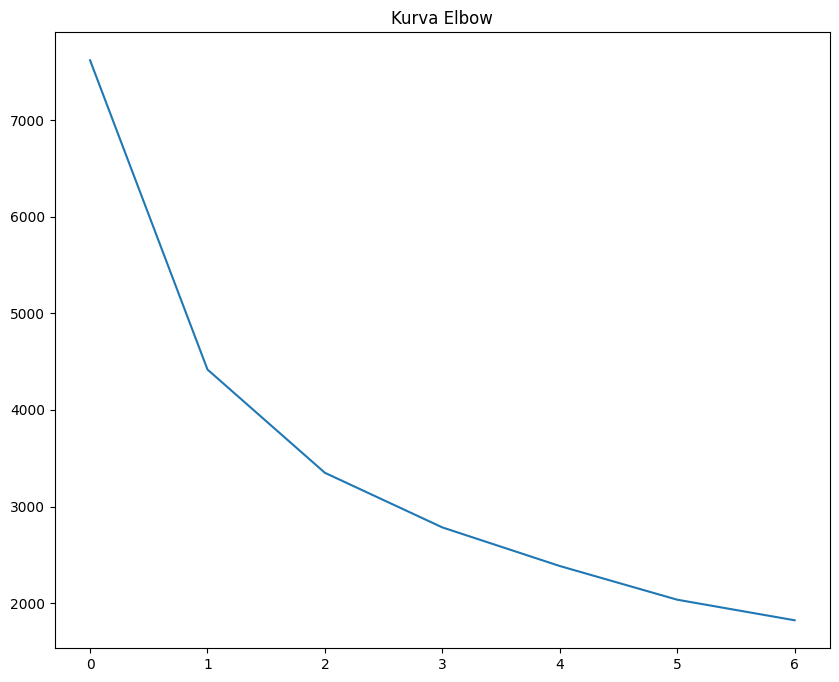

In [ ]:
sse = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, max_iter=50)
    kmeans.fit(rfm_normalized)

    sse.append(kmeans.inertia_)

plt.title("Kurva Elbow")
plt.plot(sse);

Mengitung silhouette score
For n_cluster=2, silhouette scorenya adalah:0.542236720904779
For n_cluster=3, silhouette scorenya adalah:0.5097197534398498
For n_cluster=4, silhouette scorenya adalah:0.47921550766170085
For n_cluster=5, silhouette scorenya adalah:0.46869714995069894
For n_cluster=6, silhouette scorenya adalah:0.4171936438631818
For n_cluster=7, silhouette scorenya adalah:0.41462566861447775
For n_cluster=8, silhouette scorenya adalah:0.407409176695513


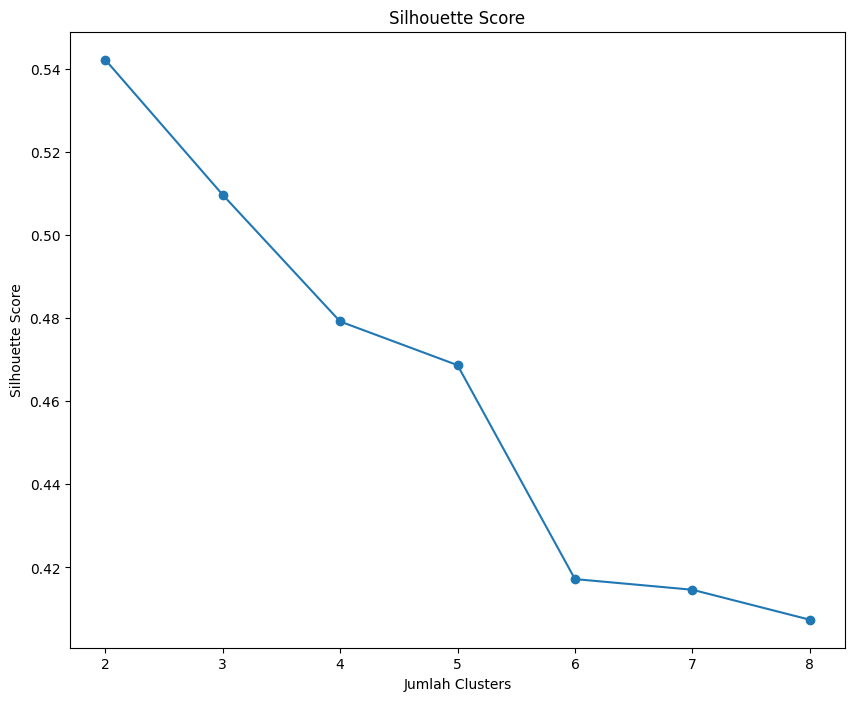

In [ ]:
print("Mengitung silhouette score")
silhouette = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, max_iter=50)
    kmeans.fit(rfm_normalized)

    cluster_labels = kmeans.labels_

    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_cluster={0}, silhouette scorenya adalah:{1}".format(num_clusters, silhouette_avg))
# Plotting silhouette score
plt.plot(range_n_clusters, silhouette, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Jumlah Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
# pilih k = 3
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=50)
kmeans.fit(rfm_normalized)
rfm_normalized.loc[:,'CustomerID'] = rfm_df_id['CustomerID']
rfm_normalized['cluster'] = kmeans.labels_
print(rfm_normalized)

      Monetary  Frequency   Recency CustomerID  cluster
0     1.660541   1.082775 -0.917707        NaN        0
1     0.267485  -0.456323 -0.189082    12347.0        2
2     0.245481  -0.028230 -0.748027    12348.0        2
3    -0.543503  -0.599021  2.156491    12349.0        1
4     0.660439   0.094083 -0.578347    12350.0        2
...        ...        ...       ...        ...      ...
4253 -0.628769  -0.670370  1.837094    18172.0        1
4254 -0.684086  -0.700948  0.868921    18173.0        1
4255 -0.630182  -0.649985 -0.857820    18174.0        2
4256  0.405135   6.576643 -0.897744    18176.0        0
4257  0.289683  -0.058808 -0.508479    18177.0        2

[4258 rows x 5 columns]


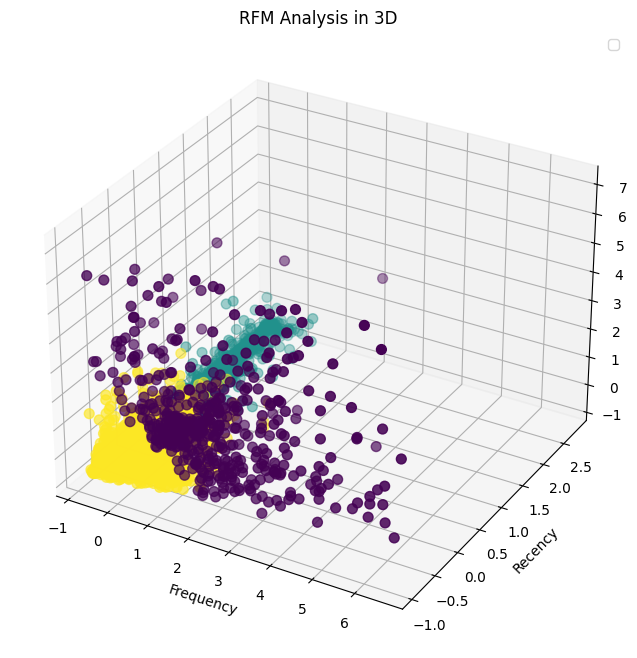

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_normalized['Frequency'], rfm_normalized['Recency'], rfm_normalized['Monetary'], c=rfm_normalized['cluster'], marker='o', s=50)

ax.set_xlabel('Frequency')
ax.set_ylabel('Recency')
ax.set_zlabel('Monetary')
ax.legend()

ax.set_title('RFM Analysis in 3D')
plt.show()

# K-Means Quantity and Spending

In [ ]:
# Clustering untuk quantity dan spending
quantity_spending = df.groupby('CustomerID')[['Quantity', 'Spending']].sum()
quantity_spending = quantity_spending.reset_index()
print(quantity_spending)

     CustomerID  Quantity  Spending
0       12346.0     74215  77183.60
1       12347.0      2458   4310.00
2       12348.0      2341   1797.24
3       12349.0       631   1757.55
4       12350.0       197    334.40
...         ...       ...       ...
4334    18280.0        45    180.60
4335    18281.0        54     80.82
4336    18282.0       103    178.05
4337    18283.0      1357   2045.53
4338    18287.0      1586   1837.28

[4339 rows x 3 columns]


In [ ]:
Q1 = quantity_spending['Spending'].quantile(0.05)
Q3 = quantity_spending['Spending'].quantile(0.95)
IQR = Q3 - Q1
quantity_spending = quantity_spending[(quantity_spending['Spending'] >= Q1 - 1.5 * IQR) & (quantity_spending['Spending'] <= Q3 + 1.5 * IQR)]
print(quantity_spending)

     CustomerID  Quantity  Spending
1       12347.0      2458   4310.00
2       12348.0      2341   1797.24
3       12349.0       631   1757.55
4       12350.0       197    334.40
5       12352.0       536   2506.04
...         ...       ...       ...
4334    18280.0        45    180.60
4335    18281.0        54     80.82
4336    18282.0       103    178.05
4337    18283.0      1357   2045.53
4338    18287.0      1586   1837.28

[4276 rows x 3 columns]


In [ ]:
Q1 = quantity_spending['Quantity'].quantile(0.05)
Q3 = quantity_spending['Quantity'].quantile(0.95)
IQR = Q3 - Q1
quantity_spending = quantity_spending[(quantity_spending['Quantity'] >= Q1 - 1.5 * IQR) & (quantity_spending['Quantity'] <= Q3 + 1.5 * IQR)]
print(quantity_spending)

     CustomerID  Quantity  Spending
1       12347.0      2458   4310.00
2       12348.0      2341   1797.24
3       12349.0       631   1757.55
4       12350.0       197    334.40
5       12352.0       536   2506.04
...         ...       ...       ...
4334    18280.0        45    180.60
4335    18281.0        54     80.82
4336    18282.0       103    178.05
4337    18283.0      1357   2045.53
4338    18287.0      1586   1837.28

[4261 rows x 3 columns]


In [ ]:
scaler_qs = StandardScaler()
qsm= quantity_spending[['Quantity', 'Spending']]
qsm = scaler_qs.fit_transform(qsm)
qsm= pd.DataFrame(qsm, columns=['Quantity', 'Spending'])
print(qsm)

      Quantity  Spending
0     1.650754  1.692405
1     1.536774  0.274136
2    -0.129089  0.251733
3    -0.551887 -0.551531
4    -0.221637  0.674201
...        ...       ...
4256 -0.699963 -0.638340
4257 -0.691196 -0.694658
4258 -0.643460 -0.639779
4259  0.578173  0.414277
4260  0.801262  0.296735

[4261 rows x 2 columns]


In [ ]:
kmeans_qs = KMeans(n_clusters=4, max_iter=50)
kmeans_qs.fit(qsm)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KMeans(max_iter=50, n_clusters=4)

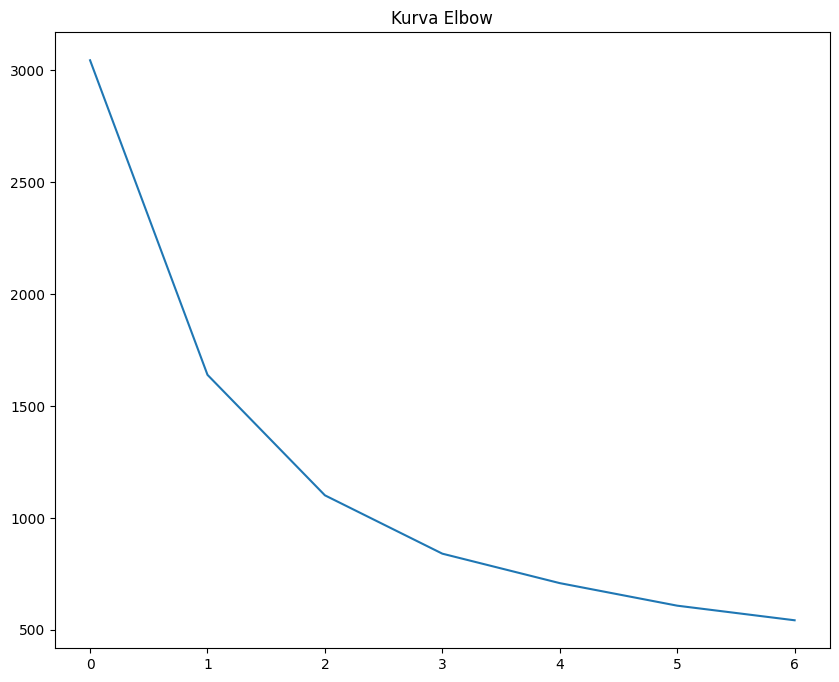

In [ ]:
sse = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans_qs = KMeans(n_clusters=num_clusters, n_init=10, max_iter=50)
    kmeans_qs.fit(qsm)

    sse.append(kmeans_qs.inertia_)

plt.title("Kurva Elbow")
plt.plot(sse);

Mengitung silhouette score
For n_cluster=2, silhouette scorenya adalah:0.7569212010786046
For n_cluster=3, silhouette scorenya adalah:0.6649453893351883
For n_cluster=4, silhouette scorenya adalah:0.6316167966025017
For n_cluster=5, silhouette scorenya adalah:0.5737091229640479
For n_cluster=6, silhouette scorenya adalah:0.5335734715738674
For n_cluster=7, silhouette scorenya adalah:0.5204351094708505
For n_cluster=8, silhouette scorenya adalah:0.4884928201374732


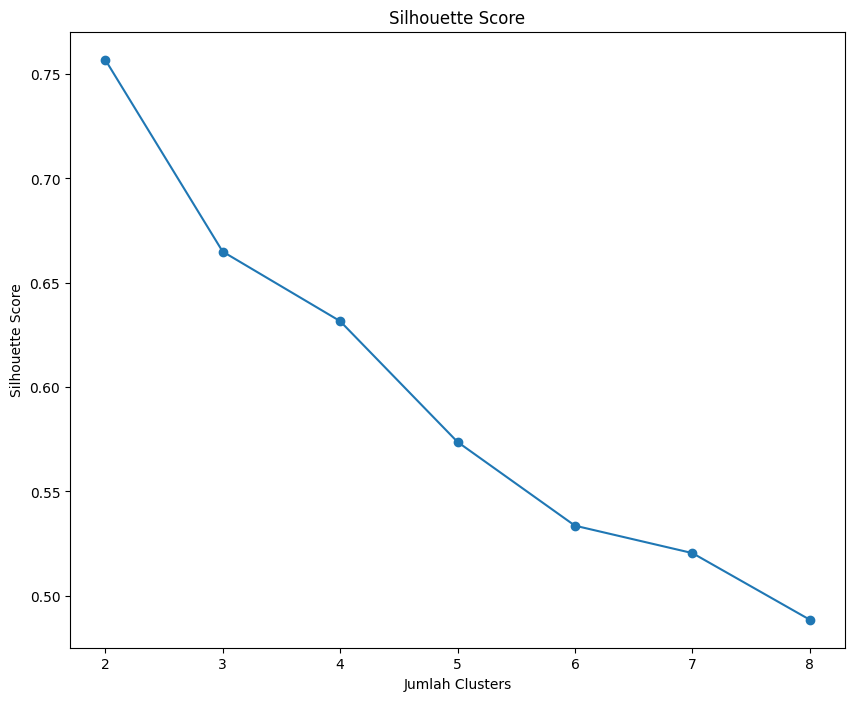

In [ ]:
print("Mengitung silhouette score")
silhouette = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans_qs = KMeans(n_clusters=num_clusters, n_init=10, max_iter=50)
    kmeans_qs.fit(qsm)

    cluster_labels = kmeans_qs.labels_

    silhouette_avg = silhouette_score(qsm, cluster_labels)
    silhouette.append(silhouette_avg)
    print("For n_cluster={0}, silhouette scorenya adalah:{1}".format(num_clusters, silhouette_avg))
# Plotting silhouette scores
plt.plot(range_n_clusters, silhouette, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Jumlah Clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
# pilih k = 2
kmeans_qs = KMeans(n_clusters=2, n_init=10, max_iter=50)
kmeans_qs.fit(qsm)
centroids = kmeans_qs.cluster_centers_
qsm.loc[:,'CustomerID'] = quantity_spending['CustomerID']
qsm['cluster'] = kmeans_qs.labels_
print(qsm)

      Quantity  Spending CustomerID  cluster
0     1.650754  1.692405        NaN        0
1     1.536774  0.274136    12347.0        1
2    -0.129089  0.251733    12348.0        1
3    -0.551887 -0.551531    12349.0        1
4    -0.221637  0.674201    12350.0        1
...        ...       ...        ...      ...
4256 -0.699963 -0.638340    18176.0        1
4257 -0.691196 -0.694658    18177.0        1
4258 -0.643460 -0.639779    18178.0        1
4259  0.578173  0.414277    18179.0        1
4260  0.801262  0.296735    18180.0        1

[4261 rows x 4 columns]


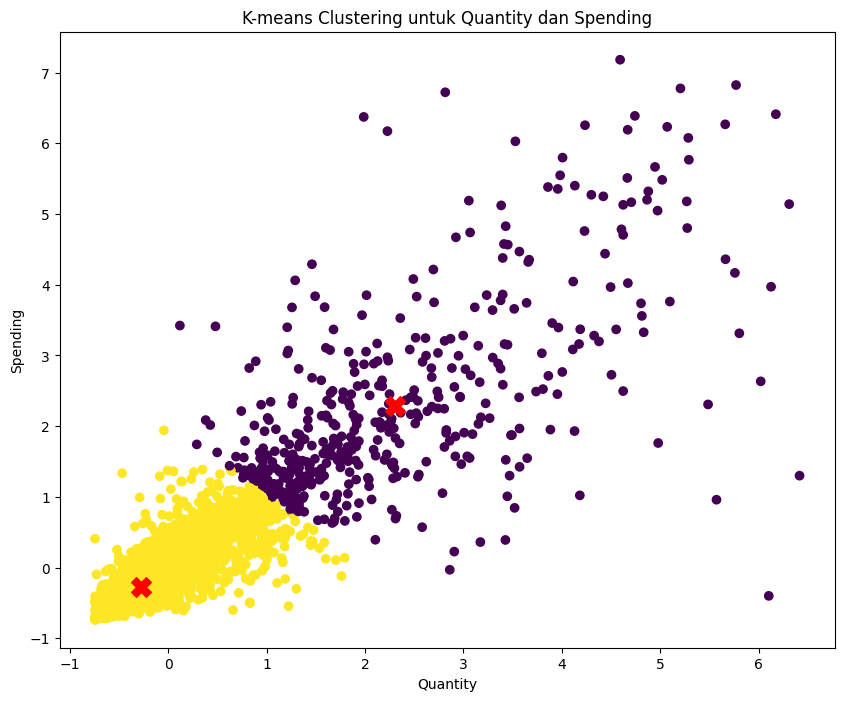

In [ ]:
plt.scatter(qsm['Quantity'], qsm['Spending'], c=qsm['cluster'], cmap='viridis', label='Data Points')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.xlabel('Quantity')
plt.ylabel('Spending')
plt.title('K-means Clustering untuk Quantity dan Spending')
plt.show()

# Frequency and Monetary

In [ ]:
fm =['Frequency_log','Monetary_log']
X_fm=rfm_df[fm].values
fm_df = X_fm
print(fm_df)
# scaler_fm= StandardScaler()
# fm_df=scaler_fm.fit_transform(X_fm)
# print(fm_df)

[[5.20400669 8.36869318]
 [3.4339872  7.49400743]
 [4.29045944 7.47167607]
 ...
 [2.48490665 5.18206441]
 [6.58063914 7.6234122 ]
 [4.24849524 7.5160415 ]]


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(fm_df)
y_kmeans= kmeans.predict(fm_df)
rfm_df['cluster fm'] = y_kmeans
print(rfm_df)

      Monetary  Frequency  Recency  R  F  M RFMGroup  RFMScore  Recency_log  \
1      4310.00        182        2  1  1  1      111         3     0.693147   
2      1797.24         31       75  3  3  1      331         7     4.317488   
3      1757.55         73       19  1  2  1      121         4     2.944439   
4       334.40         17      310  4  4  3      443        11     5.736572   
5      2506.04         85       36  2  2  1      221         5     3.583519   
...        ...        ...      ... .. .. ..      ...       ...          ...   
4334    180.60         10      278  4  4  4      444        12     5.627621   
4335     80.82          7      181  4  4  4      444        12     5.198497   
4336    178.05         12        8  1  4  4      144         9     2.079442   
4337   2045.53        721        4  1  1  1      111         3     1.386294   
4338   1837.28         70       43  2  2  1      221         5     3.761200   

      Frequency_log  Monetary_log  cluster fm  
1  

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



<ipython-input-274-9f87fc0786ae>:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



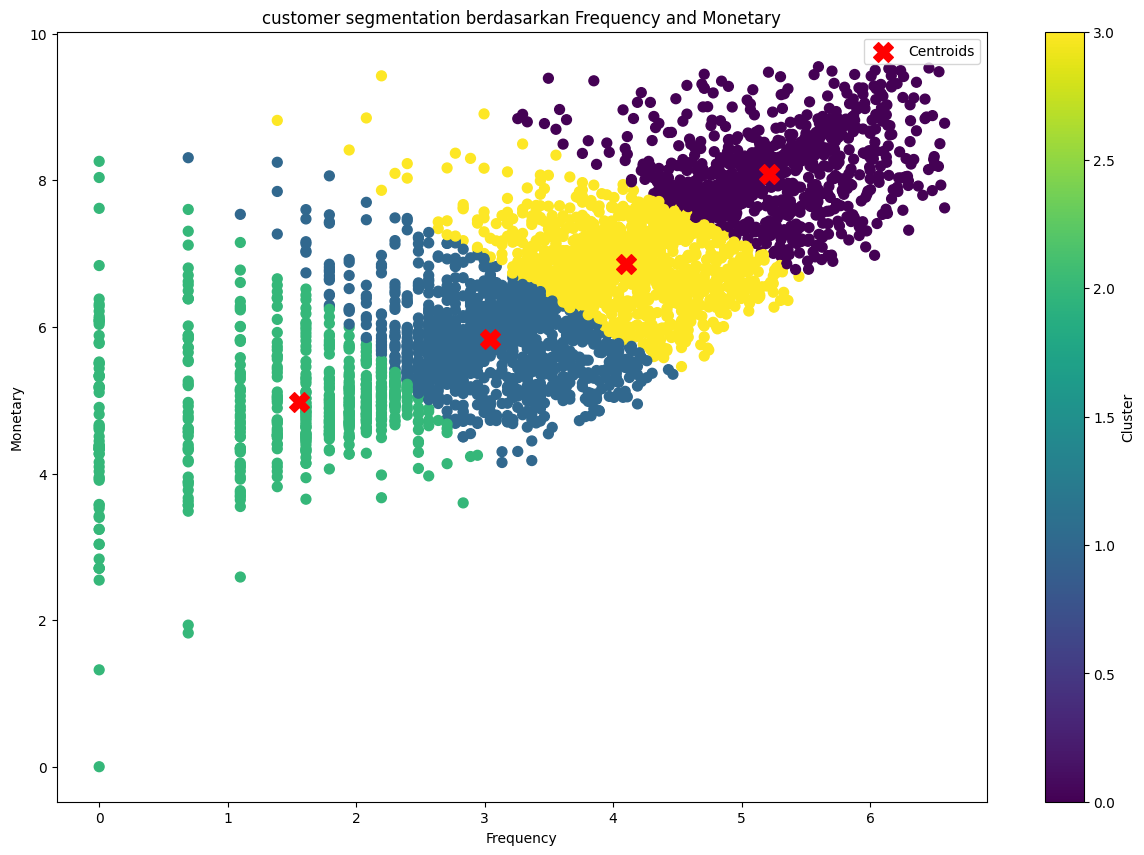

In [ ]:
#plotting frequency and monetary

cmap = plt.cm.get_cmap('viridis', 4)
plt.figure(figsize=(15,10))
plt.title('customer segmentation berdasarkan Frequency and Monetary')
scatter = plt.scatter(fm_df[:, 0], fm_df[:, 1], c=y_kmeans, s=50)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=200, c='red', label='Centroids');

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.xlabel('Frequency')
plt.ylabel('Monetary')

plt.legend()
plt.show()

# Recency and Monetary

In [ ]:
rm=['Recency_log','Monetary_log']
X_rm=rfm_df[rm].values
rm_df = X_rm
# scaler_rm=StandardScaler()
# rm_df=scaler_rm.fit_transform(X_rm)
print(rm_df)

[[0.69314718 8.36869318]
 [4.31748811 7.49400743]
 [2.94443898 7.47167607]
 ...
 [2.07944154 5.18206441]
 [1.38629436 7.6234122 ]
 [3.76120012 7.5160415 ]]


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(rm_df)
y_kmeans= kmeans.predict(rm_df)
rfm_df['cluster rm'] = y_kmeans
print(rfm_df)

      Monetary  Frequency  Recency  R  F  M RFMGroup  RFMScore  Recency_log  \
1      4310.00        182        2  1  1  1      111         3     0.693147   
2      1797.24         31       75  3  3  1      331         7     4.317488   
3      1757.55         73       19  1  2  1      121         4     2.944439   
4       334.40         17      310  4  4  3      443        11     5.736572   
5      2506.04         85       36  2  2  1      221         5     3.583519   
...        ...        ...      ... .. .. ..      ...       ...          ...   
4334    180.60         10      278  4  4  4      444        12     5.627621   
4335     80.82          7      181  4  4  4      444        12     5.198497   
4336    178.05         12        8  1  4  4      144         9     2.079442   
4337   2045.53        721        4  1  1  1      111         3     1.386294   
4338   1837.28         70       43  2  2  1      221         5     3.761200   

      Frequency_log  Monetary_log  cluster fm  clus

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



<ipython-input-278-c6a84aa96fe9>:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



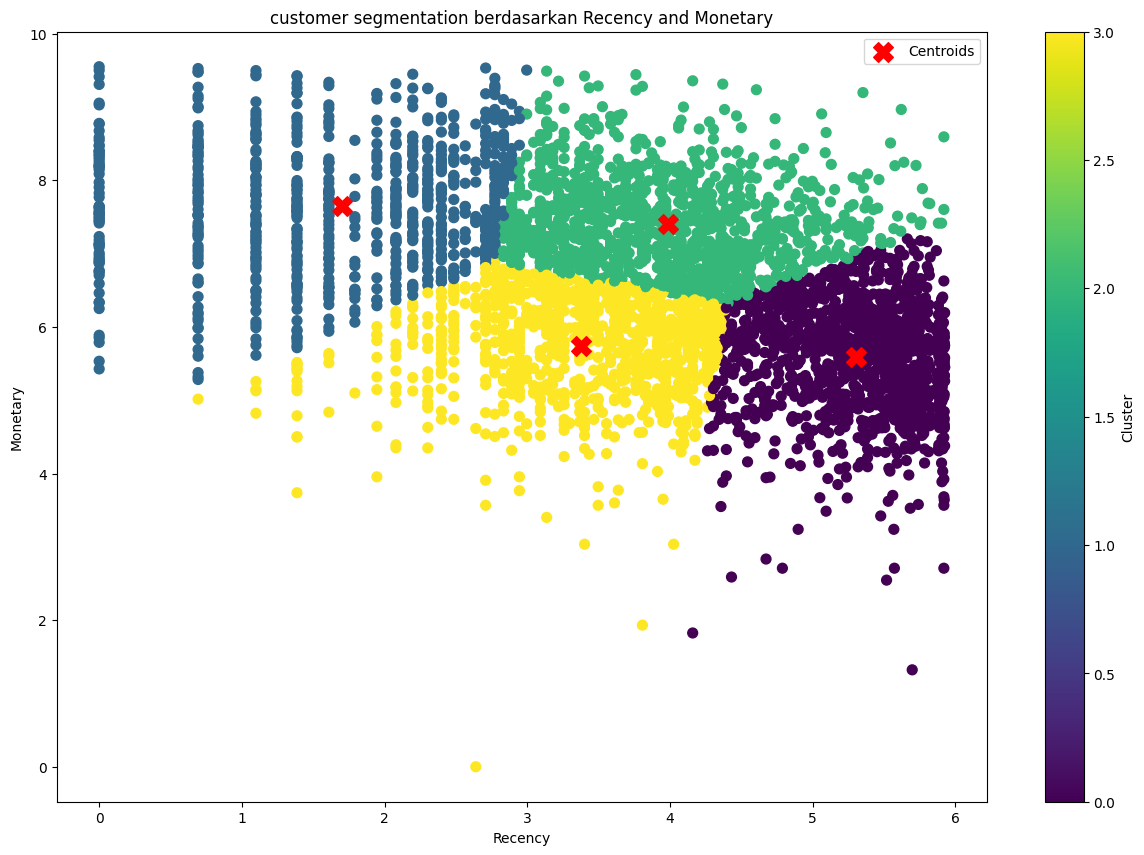

In [ ]:
#plotting recency and monetary
cmap = plt.cm.get_cmap('viridis', 4)
plt.figure(figsize=(15,10))
plt.title('customer segmentation berdasarkan Recency and Monetary')
scatter = plt.scatter(rm_df[:, 0], rm_df[:, 1], c=y_kmeans, s=50)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=200, c='red', label='Centroids');

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.xlabel('Recency')
plt.ylabel('Monetary')

plt.legend()
plt.show()

# Frequency Recency Monetary

In [ ]:
rfm=['Recency_log','Frequency_log','Monetary_log']
X_features=rfm_df[rfm].values
X = X_features
# scaler=StandardScaler()
# X=scaler.fit_transform(X_features)
print(X)

[[0.69314718 5.20400669 8.36869318]
 [4.31748811 3.4339872  7.49400743]
 [2.94443898 4.29045944 7.47167607]
 ...
 [2.07944154 2.48490665 5.18206441]
 [1.38629436 6.58063914 7.6234122 ]
 [3.76120012 4.24849524 7.5160415 ]]


In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans= kmeans.predict(X)
rfm_df['cluster rfm'] = y_kmeans
print(rfm_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



      Monetary  Frequency  Recency  R  F  M RFMGroup  RFMScore  Recency_log  \
1      4310.00        182        2  1  1  1      111         3     0.693147   
2      1797.24         31       75  3  3  1      331         7     4.317488   
3      1757.55         73       19  1  2  1      121         4     2.944439   
4       334.40         17      310  4  4  3      443        11     5.736572   
5      2506.04         85       36  2  2  1      221         5     3.583519   
...        ...        ...      ... .. .. ..      ...       ...          ...   
4334    180.60         10      278  4  4  4      444        12     5.627621   
4335     80.82          7      181  4  4  4      444        12     5.198497   
4336    178.05         12        8  1  4  4      144         9     2.079442   
4337   2045.53        721        4  1  1  1      111         3     1.386294   
4338   1837.28         70       43  2  2  1      221         5     3.761200   

      Frequency_log  Monetary_log  cluster fm  clus

<ipython-input-289-a737442610b1>:1: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



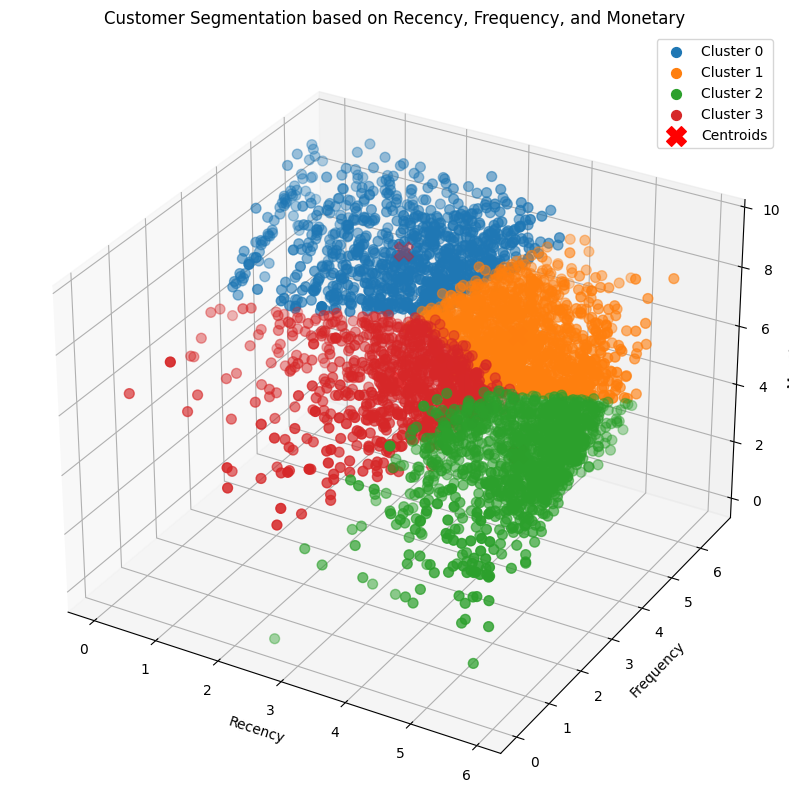

In [ ]:
cmap = plt.cm.get_cmap('viridis', 4)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')  # Specify 3D projection

# Scatter plot for each cluster
for cluster_label in range(4):
    cluster_data = X[y_kmeans == cluster_label]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], s=50, label=f'Cluster {cluster_label}')

# Plotting centroids
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], marker='X', s=200, c='red', label='Centroids')

# Adding legend and labels
ax.legend()
ax.set_title('Customer Segmentation based on Recency, Frequency, and Monetary')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')



plt.show()

<ipython-input-291-81a58e2dbc1a>:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



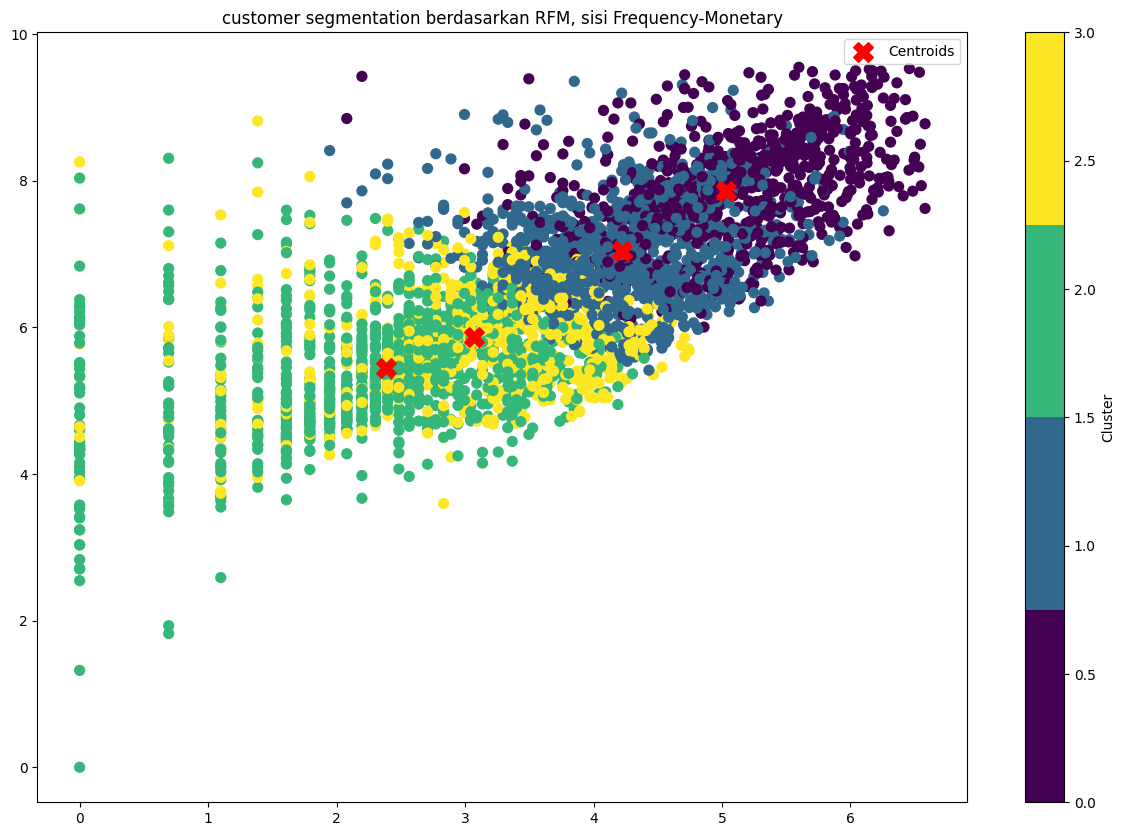

In [ ]:
# 2D, sisi frequency monetary
cmap = plt.cm.get_cmap('viridis', 4)
fig = plt.figure(figsize=(15,10))
plt.title('customer segmentation berdasarkan RFM, sisi Frequency-Monetary')
scatter = plt.scatter(X[:, 1], X[:, 2], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], marker='X', s=200, c='red', label='Centroids');

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.legend()
plt.show()

<ipython-input-290-1cfbd1e44498>:2: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



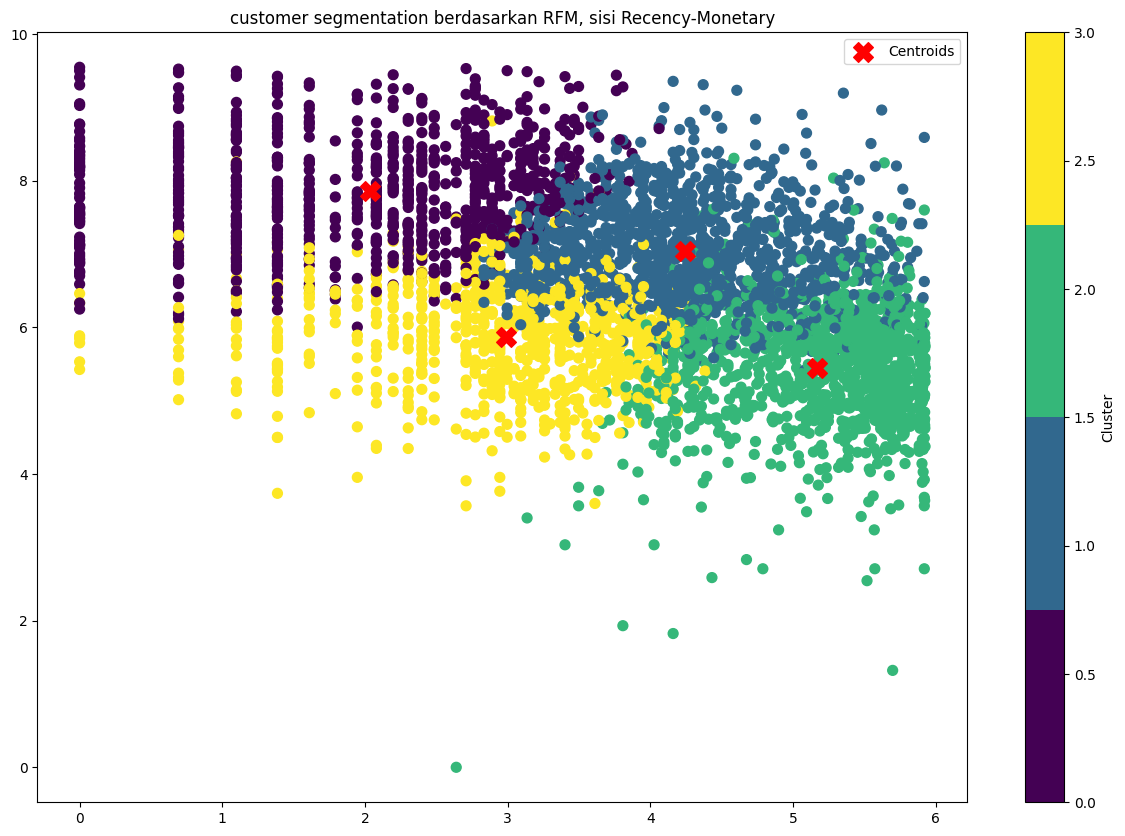

In [ ]:
# 2D, sisi recency monetary
cmap = plt.cm.get_cmap('viridis', 4)
fig = plt.figure(figsize=(15,10))
plt.title('customer segmentation berdasarkan RFM, sisi Recency-Monetary')
scatter = plt.scatter(X[:, 0], X[:, 2], c=y_kmeans, s=50, cmap=cmap)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], marker='X', s=200, c='red', label='Centroids');

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.legend()
plt.show()

# DBSCAN

# Frequency and Monetary

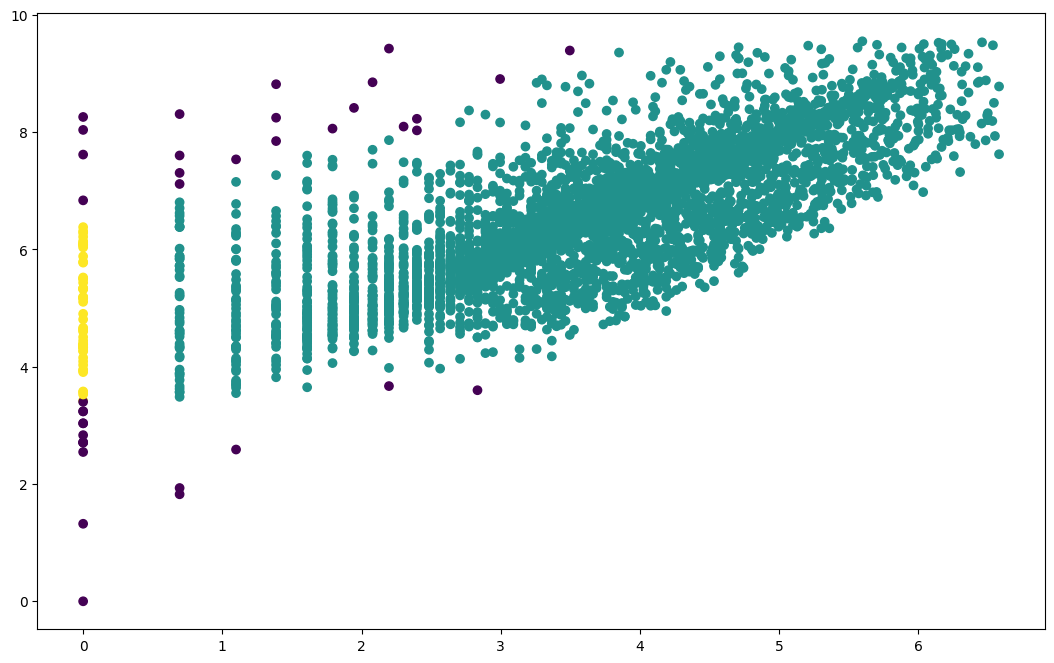

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
y_pred = DBSCAN(eps=0.5, min_samples=15).fit_predict(fm_df)
plt.figure(figsize=(13,8))
plt.scatter(fm_df[:,0], fm_df[:,1], c=y_pred);

# Recency and Monetary

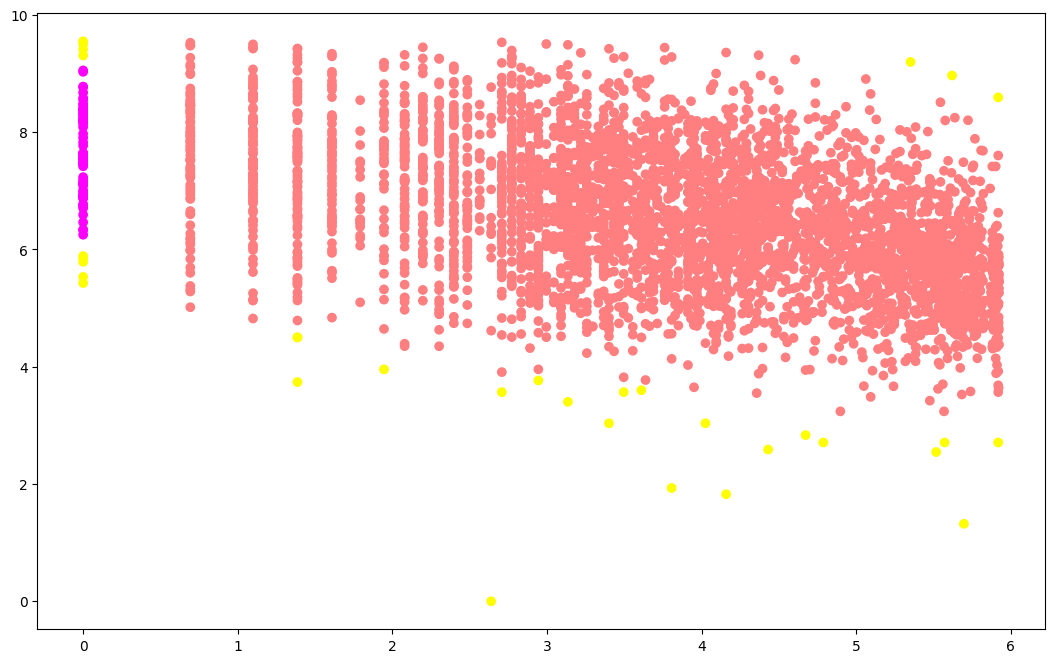

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
y_pred = DBSCAN(eps=0.5, min_samples=15).fit_predict(rm_df)
plt.figure(figsize=(13,8))
plt.scatter(rm_df[:,0], rm_df[:,1], c=y_pred,cmap='spring_r');

# Frequency Recency Monetary

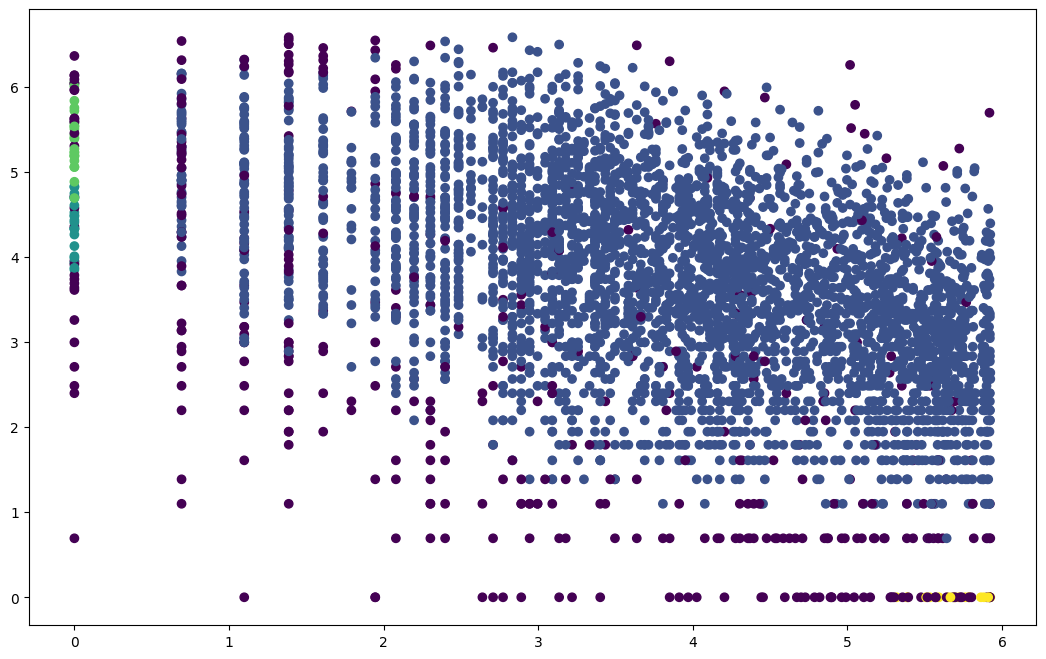

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
y_pred = DBSCAN(eps=0.5, min_samples=15).fit_predict(X)
plt.figure(figsize=(13,8))
plt.scatter(X[:,0], X[:,1], c=y_pred);